In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_swiss_roll, make_moons
import torch
device = 'cpu'
from tqdm.auto import tqdm
torch.manual_seed(0)
np.random.seed(0)

In [2]:
swiss_roll, _ = make_swiss_roll(1000,noise=0.2)
swiss_roll = swiss_roll[:, [0, 2]]/10.0

moons, _ = make_moons(10**4, noise=0.1)

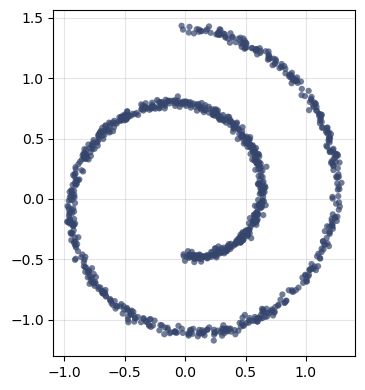

In [3]:
#plot swiss roll
fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(
    swiss_roll[:,0], swiss_roll[:,1], s=20,
    edgecolors='none', alpha=0.7, color=plt.cm.cividis(0.2)
)
# ax.set(xlim=(-2.3, 2.7), ylim=(-2.4, 2.6))
ax.set_aspect('equal', adjustable='box')
ax.grid(visible=True, which='both', color='gray', alpha=0.2, linestyle='-')
ax.set_axisbelow(True)
fig.tight_layout()

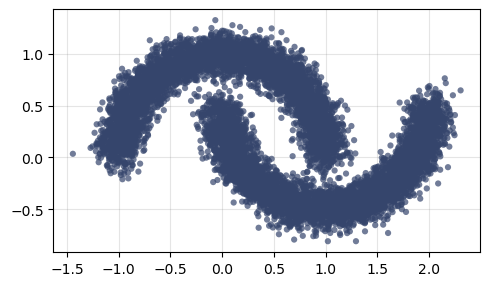

In [4]:
#plot moons
fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(
    moons[:,0], moons[:,1], s=20,
    edgecolors='none', alpha=0.7, color=plt.cm.cividis(0.2)
)
# ax.set(xlim=(-2.3, 2.7), ylim=(-2.4, 2.6))
ax.set_aspect('equal', adjustable='box')
ax.grid(visible=True, which='both', color='gray', alpha=0.2, linestyle='-')
ax.set_axisbelow(True)
fig.tight_layout()


### Diffusion Model: Forward Process

In [40]:
class LinearNoiseScheduler():
    '''Inspired from: https://github.com/explainingai-code/DDPM-Pytorch and https://akansh12.github.io/Troj_diffusion_seminar/ddpm.html'''
    def __init__(self, num_timesteps, beta_start, beta_end):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.betas = self.betas.to(device)
        self.alphas = 1 - self.betas
        self.alphas_cum_prod = torch.cumprod(self.alphas, 0)
        self.sqrt_alphas_cum_prod = torch.sqrt(self.alphas_cum_prod)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alphas_cum_prod)

    def add_noise(self, original, noise, t):
        original_shape = original.shape
        # batch_size = original_shape[0]

        sqrt_alpha_cum_prod = self.sqrt_alphas_cum_prod[t]
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod[t]

        # for _ in range(len(original_shape) - 1):
        #     sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
        #     sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)

        return sqrt_alpha_cum_prod * original + sqrt_one_minus_alpha_cum_prod * noise.to(original.device)

    def sample_prev_timestep(self, xt, t, noise_pred):
        x0 = (xt - self.sqrt_one_minus_alpha_cum_prod[t] * noise_pred)/(self.sqrt_alphas_cum_prod[t])
        x0 = torch.clamp(x0, -1, 1)

        mean = xt - ((self.betas[t])*noise_pred)/(self.sqrt_one_minus_alpha_cum_prod[t])
        mean = mean/torch.sqrt(self.alphas[t])

        if t == 0:

            return mean, mean
        else:
            variance = (1 - self.alphas_cum_prod[t-1])/(1 - self.alphas_cum_prod[t])
            variance = variance*self.betas[t]
            sigma = torch.sqrt(variance)

            z = torch.randn_like(xt).to(xt.device)

            return mean + sigma*z, x0

Text(0.5, 1.0, 'Sqrt One Minus Alpha Cum Prod')

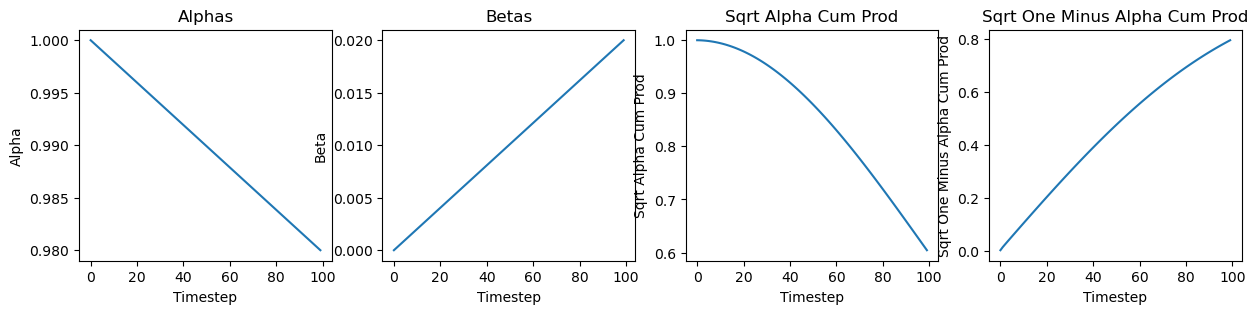

In [60]:
linear_scheduler = LinearNoiseScheduler(100, 1e-5, 0.02)
plt.figure(figsize=(15,3))
plt.subplot(1,4,1)
plt.plot(linear_scheduler.alphas.cpu())
plt.xlabel('Timestep')
plt.ylabel('Alpha')
plt.title('Alphas')

plt.subplot(1,4,2)
plt.plot(linear_scheduler.betas.cpu())
plt.xlabel('Timestep')
plt.ylabel('Beta')
plt.title('Betas')

plt.subplot(1,4,3)
plt.plot(linear_scheduler.sqrt_alphas_cum_prod.cpu())
plt.xlabel('Timestep')
plt.ylabel('Sqrt Alpha Cum Prod')
plt.title('Sqrt Alpha Cum Prod')

plt.subplot(1,4,4)
plt.plot(linear_scheduler.sqrt_one_minus_alpha_cum_prod.cpu())
plt.xlabel('Timestep')
plt.ylabel('Sqrt One Minus Alpha Cum Prod')
plt.title('Sqrt One Minus Alpha Cum Prod')

### Forward Process

In [61]:
dataset_moon = torch.Tensor(moons).float()
dataset_swiss = torch.Tensor(swiss_roll).float()
# dataset.unsqueeze_(0); 

Gaussian Noise

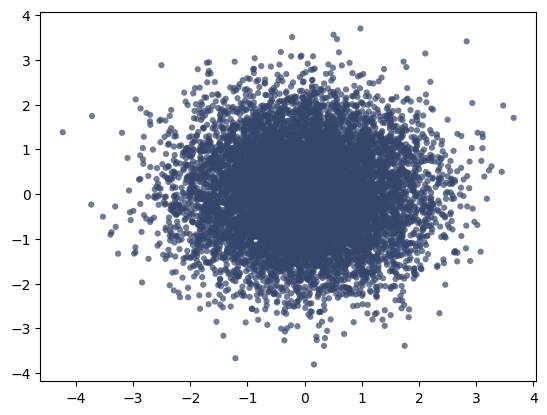

In [62]:
noise = torch.randn_like(dataset_moon)
plt.plot(figsize=(5, 5))
plt.scatter(noise[:,0], noise[:,1], s=20, edgecolors='none', alpha=0.7, color=plt.cm.cividis(0.2))

Swiss Role Dataset Forward Process

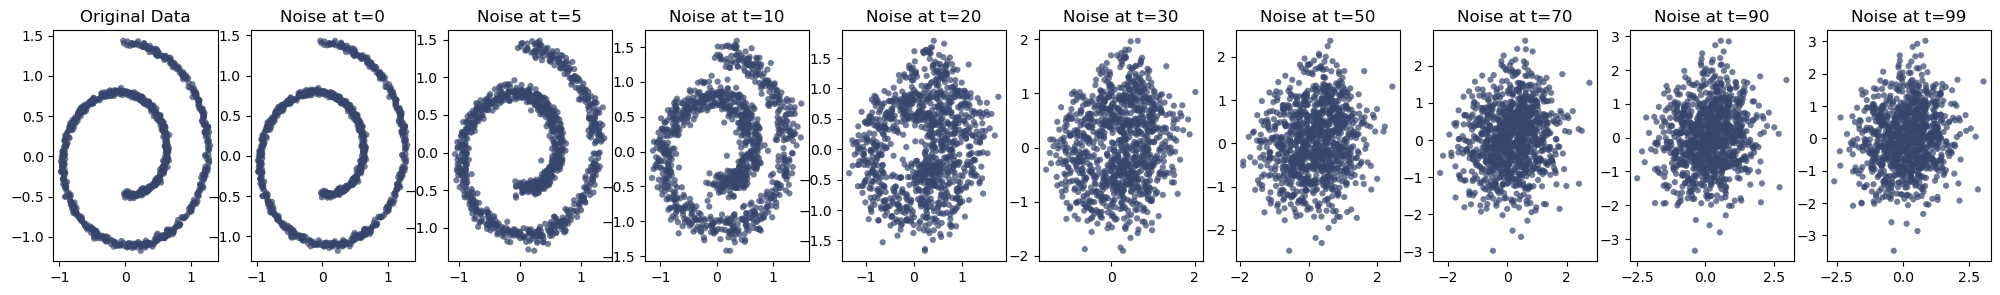

In [63]:
#ploting the added noise
noise = torch.randn_like(dataset_swiss)
steps = [0, 5, 10, 20, 30, 50, 70, 90, 99]
plt.figure(figsize=(25,3))
plt.subplot(1,10,1)
plt.scatter(dataset_swiss[:,0], dataset_swiss[:,1], s=20, edgecolors='none', alpha=0.7, color=plt.cm.cividis(0.2))
plt.title('Original Data')

for i, t in enumerate(steps):
    plt.subplot(1,10,i+2)
    noisy_data = linear_scheduler.add_noise(dataset_swiss, noise, t)
    plt.scatter(noisy_data[:,0], noisy_data[:,1], s=20, edgecolors='none', alpha=0.7, color=plt.cm.cividis(0.2))
    plt.title(f'Noise at t={t}')


Moon Dataset Forward Process

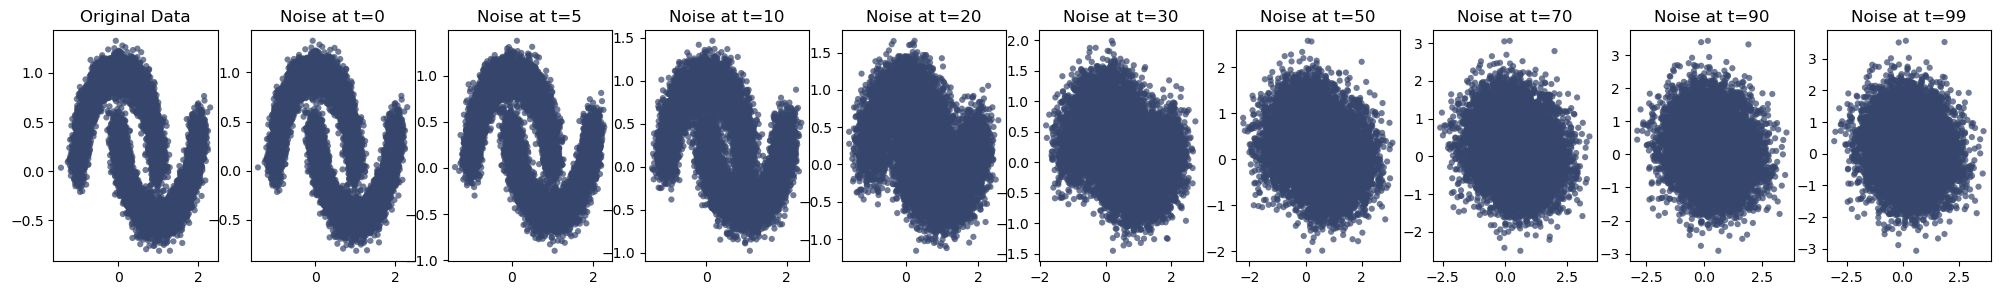

In [64]:
#ploting the added noise
noise = torch.randn_like(dataset_moon)
steps = [0, 5, 10, 20, 30, 50, 70, 90, 99]
plt.figure(figsize=(25,3))
plt.subplot(1,10,1)
plt.scatter(dataset_moon[:,0], dataset_moon[:,1], s=20, edgecolors='none', alpha=0.7, color=plt.cm.cividis(0.2))
plt.title('Original Data')

for i, t in enumerate(steps):
    plt.subplot(1,10,i+2)
    noisy_data = linear_scheduler.add_noise(dataset_moon, noise, t)
    plt.scatter(noisy_data[:,0], noisy_data[:,1], s=20, edgecolors='none', alpha=0.7, color=plt.cm.cividis(0.2))
    plt.title(f'Noise at t={t}')


In [65]:
import torch.nn as nn
import torch.nn.functional as F

class ConditionalLinear(nn.Module):
    #Oringinal source: https://github.com/acids-ircam/diffusion_models
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out
        
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = ConditionalLinear(128, 128, n_steps)
        self.lin4 = nn.Linear(128, 2)
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        x = F.softplus(self.lin3(x, y))
        return self.lin4(x)

Optimizer

In [66]:
import torch.optim as optim
num_steps = 100
model = ConditionalModel(num_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [72]:
batch_size = 128
for t in range(1000):
    permutation = torch.randperm(dataset_swiss.size()[0])
    for i in range(0, dataset_swiss.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x = dataset_swiss[indices]
        break
    break



In [67]:
permutation = torch.randperm(dataset_swiss.size()[0])

In [70]:
        loss = noise_estimation_loss(model, batch_x,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps)

1000

In [71]:
permutation

tensor([ 41,  66, 321,  86, 973, 801, 912, 991, 784, 814, 759, 695, 148, 700,
        566, 548, 154, 976, 961, 315, 271, 383, 893, 716, 467,  38, 353,  90,
        326, 632, 657, 857, 931, 666, 806, 638, 437, 291, 349,  30, 717, 332,
        184, 307, 595, 868,  79, 981, 555, 396, 135, 113, 556, 844, 262,  84,
        887, 459,  60, 547, 982, 268, 949,  32, 458, 288, 195, 121,   8, 707,
        302, 642, 679,  49, 875, 647, 179, 194, 718, 778, 526, 192, 587, 479,
        439, 212, 345, 535, 539, 649, 236, 977, 952, 861, 985, 820, 417, 301,
        471, 298,  31, 751, 872,   9, 124, 713, 613, 379, 883, 767, 131, 502,
        873, 795, 742, 140, 924, 352, 955, 422, 242, 414, 486, 809, 980, 557,
        187, 250, 633, 810, 737, 488, 399, 635, 494, 311, 979, 769, 506, 930,
        582, 226, 620, 911, 858,  94, 204, 798, 240, 995, 790, 546, 584, 772,
        835, 341, 259, 729, 761, 834, 394, 921, 913, 553, 522,  99, 954, 869,
        318, 456, 651, 765, 453, 314,  62, 788, 416, 452,  95, 4

In [ ]:
def noise_estimation_loss(model, input_data,sqrt_alpha_cum_prod,one_minus_alphas_bar_sqrt,n_steps):
    batch_size = input_data.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # x0 multiplier
    a = sqrt_alpha_cum_prod[t]
    # eps multiplier
    am1 = extract(one_minus_alphas_bar_sqrt, t, input_data)
    e = torch.randn_like(input_data)
    # model input
    x = x_0 * a + e * am1
    output = model(x, t)
    return (e - output).square().mean()

In [ ]:
# from ema import EMA
# ema = EMA(0.9)
# ema.register(model)
